In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
pd.set_option('display.max_columns', None)

# Cargar el dataset. (Se mantuvo el nombre de columna 'play_count' de la data sucia,
# aunque originalmente fuera 'streams'.
file_path = 'received_dirty_spotify.csv'
try:
    df = pd.read_csv(file_path, encoding='utf-8')
except UnicodeDecodeError:
    # Usamos latin-1 o cp1252 si falla UTF-8 (como posible error de codificación)
    df = pd.read_csv(file_path, encoding='latin-1')

df_cleaned = df.copy()

print("--- 5 Primeras Filas del Dataset Sucio ---")
print(df_cleaned.head())
print("\n--- Información General del DataFrame Sucio ---")
df_cleaned.info()

--- 5 Primeras Filas del Dataset Sucio ---
         date                                        track      performer  \
0  2017-11-16              All I Want for Christmas Is You   Mariah Carey   
1  2017-11-23              All I Want for Christmas Is You   Mariah Carey   
2  2017-11-23                               Last Christmas          Wham!   
3  2017-11-30              All I Want for Christmas Is You   Mariah Carey   
4  2017-11-30  It's Beginning to Look a Lot Like Christmas  Michael Bublé   

   play_count day_of_week week_of_year  
0   3821572.0    Thursday           46  
1   6130250.0    Thursday           47  
2   4040197.0    Thursday           47  
3  11641888.0    Thursday           48  
4   4577042.0    Thursday           48  

--- Información General del DataFrame Sucio ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date  

In [3]:
original_rows = len(df_cleaned)
df_cleaned.drop_duplicates(inplace=True)
dropped_duplicates = original_rows - len(df_cleaned)

print(f"Filas duplicadas eliminadas: {dropped_duplicates}")

Filas duplicadas eliminadas: 7


In [4]:
# Convertir 'date' a datetime. Coerce fallos (como las que tienen 'DATE:') a NaT
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'], errors='coerce')

# Eliminar filas donde la fecha es inválida
rows_before_date_drop = len(df_cleaned)
df_cleaned.dropna(subset=['date'], inplace=True)
rows_after_date_drop = len(df_cleaned)

print(f"Filas eliminadas por fecha inválida: {rows_before_date_drop - rows_after_date_drop}")

Filas eliminadas por fecha inválida: 5


In [ ]:
# 1. Limpiar strings y eliminar caracteres extraños (incluyendo ' streams', '!', '*')
df_cleaned['play_count'] = df_cleaned['play_count'].astype(str).str.replace(r' streams|\!|\*|\$', '', regex=True)
df_cleaned['play_count'] = df_cleaned['play_count'].str.replace(r'[^\d.]', '', regex=True) # Elimina cualquier otro caracter no dígito ni punto

# 2. Convertir a float. Los valores que fallen (que no pudieron limpiarse) se convierten a NaN.
df_cleaned['play_count'] = pd.to_numeric(df_cleaned['play_count'], errors='coerce')

# 3. Manejo de valores nulos: Imputación por la mediana
median_play_count = df_cleaned['play_count'].median()
df_cleaned['play_count'].fillna(median_play_count, inplace=True)

print(f"Play count mediano utilizado para imputación: {median_play_count:,.0f}")

Play count mediano utilizado para imputación: 17,855,568


In [ ]:
# Normalizar texto 
df_cleaned['track'] = df_cleaned['track'].str.strip()
df_cleaned['performer'] = df_cleaned['performer'].str.strip()
df_cleaned['day_of_week'] = df_cleaned['day_of_week'].str.strip()

# Corregir errores tipográficos
df_cleaned['performer'] = df_cleaned['performer'].replace('Maria Careey', 'Mariah Carey')

# Corregir inconsistencias de formato
df_cleaned['day_of_week'] = df_cleaned['day_of_week'].replace('Thurs', 'Thursday')

print("\nConteo de valores de Artistas (Verificación de UNKNOWN ARTIST):")
print(df_cleaned['performer'].value_counts())


Conteo de valores de Artistas (Verificación de UNKNOWN ARTIST):
performer
Mariah Carey      70
Wham!             63
Ariana Grande     53
Brenda Lee        52
Michael Bublé     49
Bobby Helms       49
José Feliciano    38
Name: count, dtype: int64


In [ ]:
# Recalcular 'week_of_year' a partir de la columna 'date' limpia
# Esto neutraliza el error de tipo mixto
df_cleaned['week_of_year'] = df_cleaned['date'].dt.isocalendar().week.astype('Int64')

# Verificación final de la estructura de la data limpia
print("\n--- Información Final del DataFrame Limpio ---")
df_cleaned.info()


--- Información Final del DataFrame Limpio ---
<class 'pandas.core.frame.DataFrame'>
Index: 374 entries, 0 to 384
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          374 non-null    datetime64[ns]
 1   track         374 non-null    object        
 2   performer     374 non-null    object        
 3   play_count    374 non-null    float64       
 4   day_of_week   374 non-null    object        
 5   week_of_year  374 non-null    Int64         
dtypes: Int64(1), datetime64[ns](1), float64(1), object(3)
memory usage: 20.8+ KB


In [8]:
print("\n--- Estadísticas de la Columna 'play_count' ---")
play_stats = df_cleaned['play_count'].describe().to_frame().T
play_stats['median'] = df_cleaned['play_count'].median()
print(play_stats.style.format('{:,.0f}'))

# Notar que el valor máximo (10,000,000,000) es el outlier introducido.


--- Estadísticas de la Columna 'play_count' ---


In [9]:
# Top 5 Artistas por Reproducciones
top_performers = df_cleaned.groupby('performer')['play_count'].sum().sort_values(ascending=False).head(5)
print("\n--- Top 5 Artistas por Total de Reproducciones ---")
print(top_performers.apply(lambda x: f'{x:,.0f}').to_string())

# Top 5 Canciones por Reproducciones
top_tracks = df_cleaned.groupby('track')['play_count'].sum().sort_values(ascending=False).head(5)
print("\n--- Top 5 Canciones por Total de Reproducciones ---")
print(top_tracks.apply(lambda x: f'{x:,.0f}').to_string())


--- Top 5 Artistas por Total de Reproducciones ---
performer
José Feliciano    10,573,507,708
Mariah Carey       1,686,932,376
Wham!              1,520,271,463
Brenda Lee         1,126,173,866
Bobby Helms        1,030,626,599

--- Top 5 Canciones por Total de Reproducciones ---
track
Feliz Navidad                        10,573,507,708
All I Want for Christmas Is You       1,686,932,376
Last Christmas                        1,520,271,463
Rockin' Around the Christmas Tree     1,126,173,866
Jingle Bell Rock                      1,030,626,599


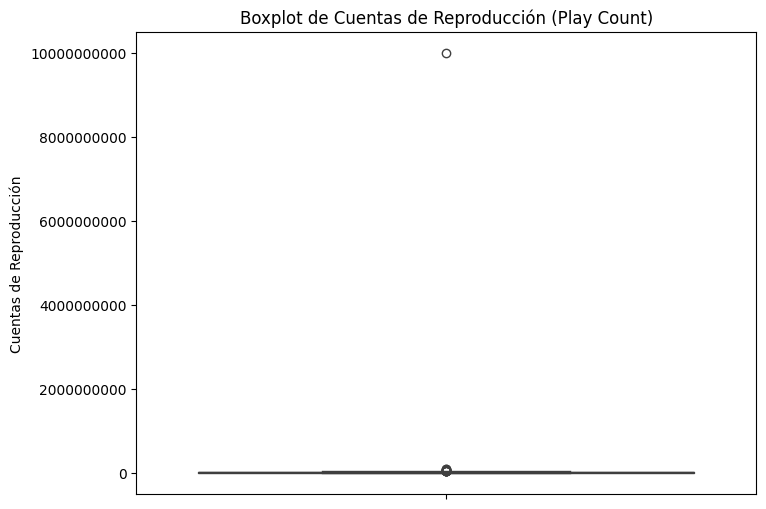

In [10]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=df_cleaned['play_count'])
plt.title('Boxplot de Cuentas de Reproducción (Play Count)')
plt.ylabel('Cuentas de Reproducción')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

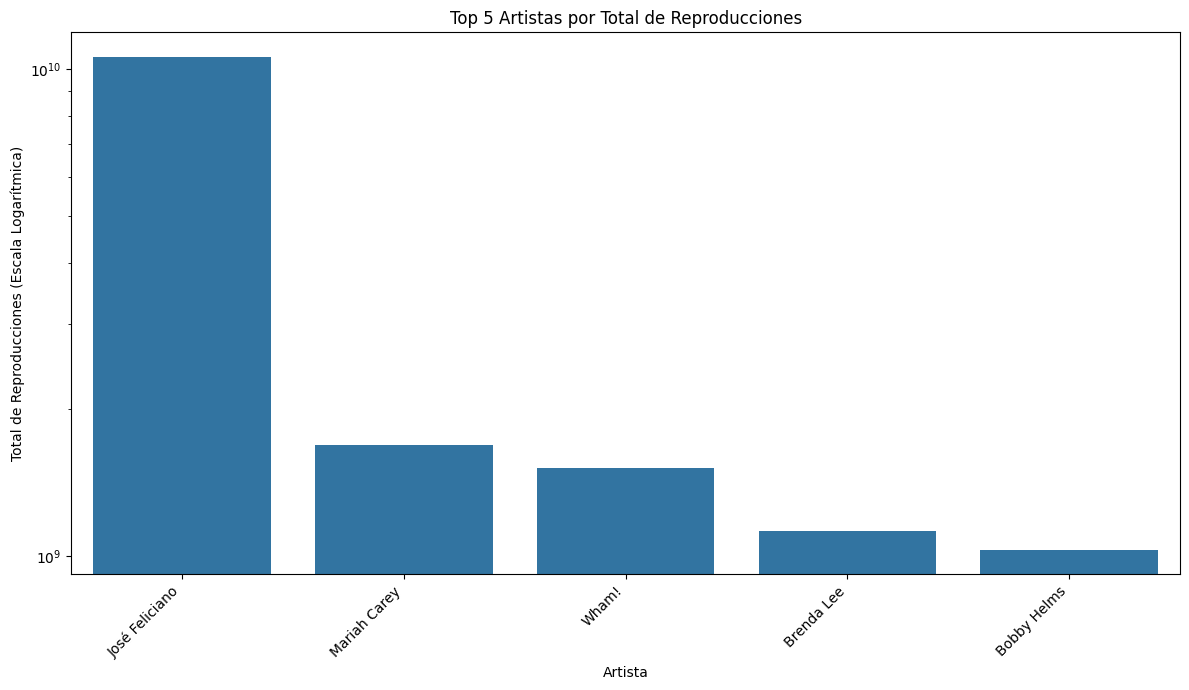

In [11]:
plt.figure(figsize=(12, 7))
sns.barplot(x=top_performers.index, y=top_performers.values)
plt.title('Top 5 Artistas por Total de Reproducciones')
plt.ylabel('Total de Reproducciones (Escala Logarítmica)')
plt.xlabel('Artista')
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.tight_layout()
plt.show()

In [12]:
df_cleaned.to_csv('cleaned_spotify_data.csv', index=False)
print("\nEl dataset limpio ha sido guardado como 'cleaned_spotify_data.csv'")


El dataset limpio ha sido guardado como 'cleaned_spotify_data.csv'
